In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from config import ANALYSIS_DATA_FILE, REPORTS_DIR

In [5]:
print("Loading Analysis Data...")
df = pd.read_parquet(ANALYSIS_DATA_FILE)
print("Analysis Data Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())

Loading Analysis Data...
Analysis Data Shape: (595829, 38)

First 5 Rows:
     Reporting Period Closing Date  ID RSSD  ID_RSSD   CERT  \
0 2002-12-31 23:59:59          NaT  1000052  1000052  12241   
1 2003-03-31 23:59:59          NaT  1000052  1000052  12241   
2 2003-06-30 23:59:59          NaT  1000052  1000052  12241   
3 2003-09-30 23:59:59          NaT  1000052  1000052  12241   
4 2003-12-31 23:59:59          NaT  1000052  1000052  12241   

  Tier1_Leverage_Ratio Total_Risk_Based_Capital_Ratio  \
0                  8.2                          10.46   
1                 8.37                          11.07   
2                 7.94                          10.39   
3                 8.19                          11.04   
4                 8.12                          10.48   

  Cash_Dividends_to_Net_Income Noncurrent_Loans_OREO_to_Tier1_ACL  \
0                        28.16                               6.91   
1                          0.0                               8.32 

/var/folders/7s/mr6zn5415w9fnd0rmvg4sgsh0000gn/T/ipykernel_13692/3464481778.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=missing.index, x=missing.values, palette="mako")


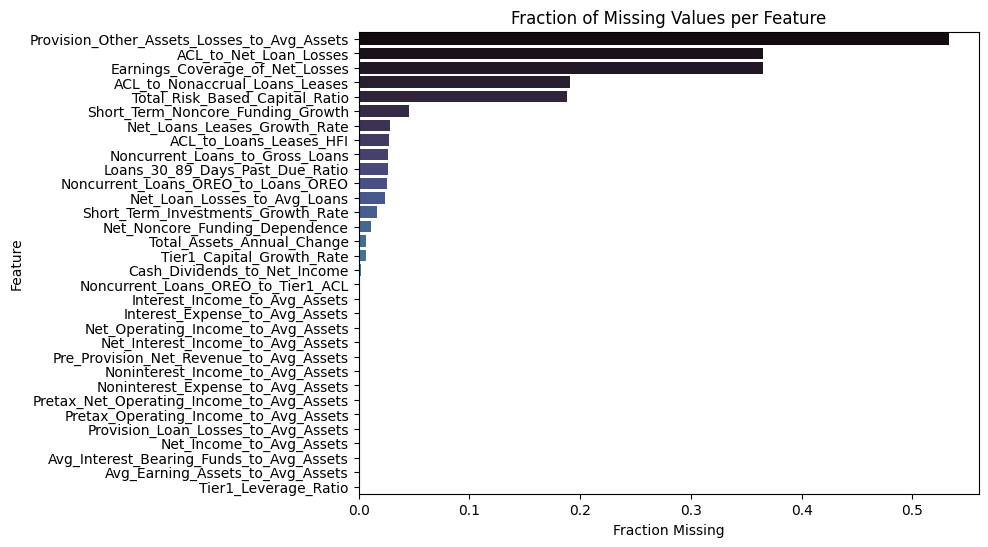

Missingness summary (top 10):
Provision_Other_Assets_Losses_to_Avg_Assets    0.533184
ACL_to_Net_Loan_Losses                         0.365508
Earnings_Coverage_of_Net_Losses                0.365508
ACL_to_Nonaccrual_Loans_Leases                 0.190611
Total_Risk_Based_Capital_Ratio                 0.188269
Short_Term_Noncore_Funding_Growth              0.045872
Net_Loans_Leases_Growth_Rate                   0.028401
ACL_to_Loans_Leases_HFI                        0.027328
Noncurrent_Loans_to_Gross_Loans                0.026157
Loans_30_89_Days_Past_Due_Ratio                0.026157
dtype: float64


In [6]:

# ==================================
#  Step 1: Basic Setup
# ==================================

df = df.sort_values(['ID RSSD', 'Reporting Period'])
df = df.groupby('ID RSSD').tail(1).reset_index(drop=True)

features = [
    'Tier1_Leverage_Ratio', 'Total_Risk_Based_Capital_Ratio',
       'Cash_Dividends_to_Net_Income', 'Noncurrent_Loans_OREO_to_Tier1_ACL',
       'Tier1_Capital_Growth_Rate', 'ACL_to_Loans_Leases_HFI',
       'ACL_to_Net_Loan_Losses', 'ACL_to_Nonaccrual_Loans_Leases',
       'Loans_30_89_Days_Past_Due_Ratio', 'Noncurrent_Loans_to_Gross_Loans',
       'Noncurrent_Loans_OREO_to_Loans_OREO', 'Net_Loan_Losses_to_Avg_Loans',
       'Earnings_Coverage_of_Net_Losses', 'Interest_Income_to_Avg_Assets',
       'Interest_Expense_to_Avg_Assets', 'Net_Interest_Income_to_Avg_Assets',
       'Noninterest_Income_to_Avg_Assets', 'Noninterest_Expense_to_Avg_Assets',
       'Pre_Provision_Net_Revenue_to_Avg_Assets',
       'Provision_Loan_Losses_to_Avg_Assets',
       'Provision_Other_Assets_Losses_to_Avg_Assets',
       'Pretax_Operating_Income_to_Avg_Assets',
       'Pretax_Net_Operating_Income_to_Avg_Assets',
       'Net_Operating_Income_to_Avg_Assets', 'Net_Income_to_Avg_Assets',
       'Net_Noncore_Funding_Dependence', 'Avg_Earning_Assets_to_Avg_Assets',
       'Avg_Interest_Bearing_Funds_to_Avg_Assets',
       'Short_Term_Noncore_Funding_Growth', 'Total_Assets_Annual_Change',
       'Net_Loans_Leases_Growth_Rate', 'Short_Term_Investments_Growth_Rate'
]

X = df[features].apply(pd.to_numeric, errors="coerce")
y = df["FAIL_FLAG"].astype(int)

# ==================================
# Step 2: Missingness Overview
# ==================================
missing = X.isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(y=missing.index, x=missing.values, palette="mako")
plt.title("Fraction of Missing Values per Feature")
plt.xlabel("Fraction Missing")
plt.ylabel("Feature")
plt.show()

print("Missingness summary (top 10):")
print(missing.head(10))



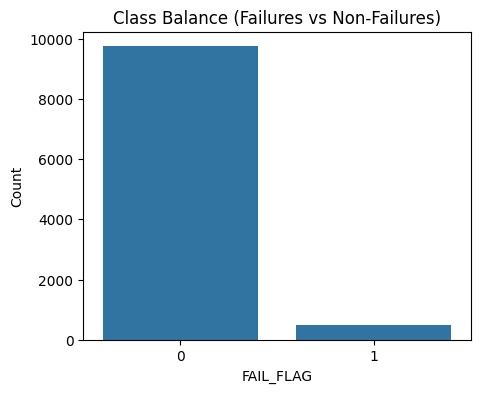

Class distribution:
FAIL_FLAG
0    0.950908
1    0.049092
Name: proportion, dtype: float64


In [7]:
# ==================================
# Step 3: Class Balance
# ==================================
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Class Balance (Failures vs Non-Failures)")
plt.xlabel("FAIL_FLAG")
plt.ylabel("Count")
plt.show()

print("Class distribution:")
print(y.value_counts(normalize=True))






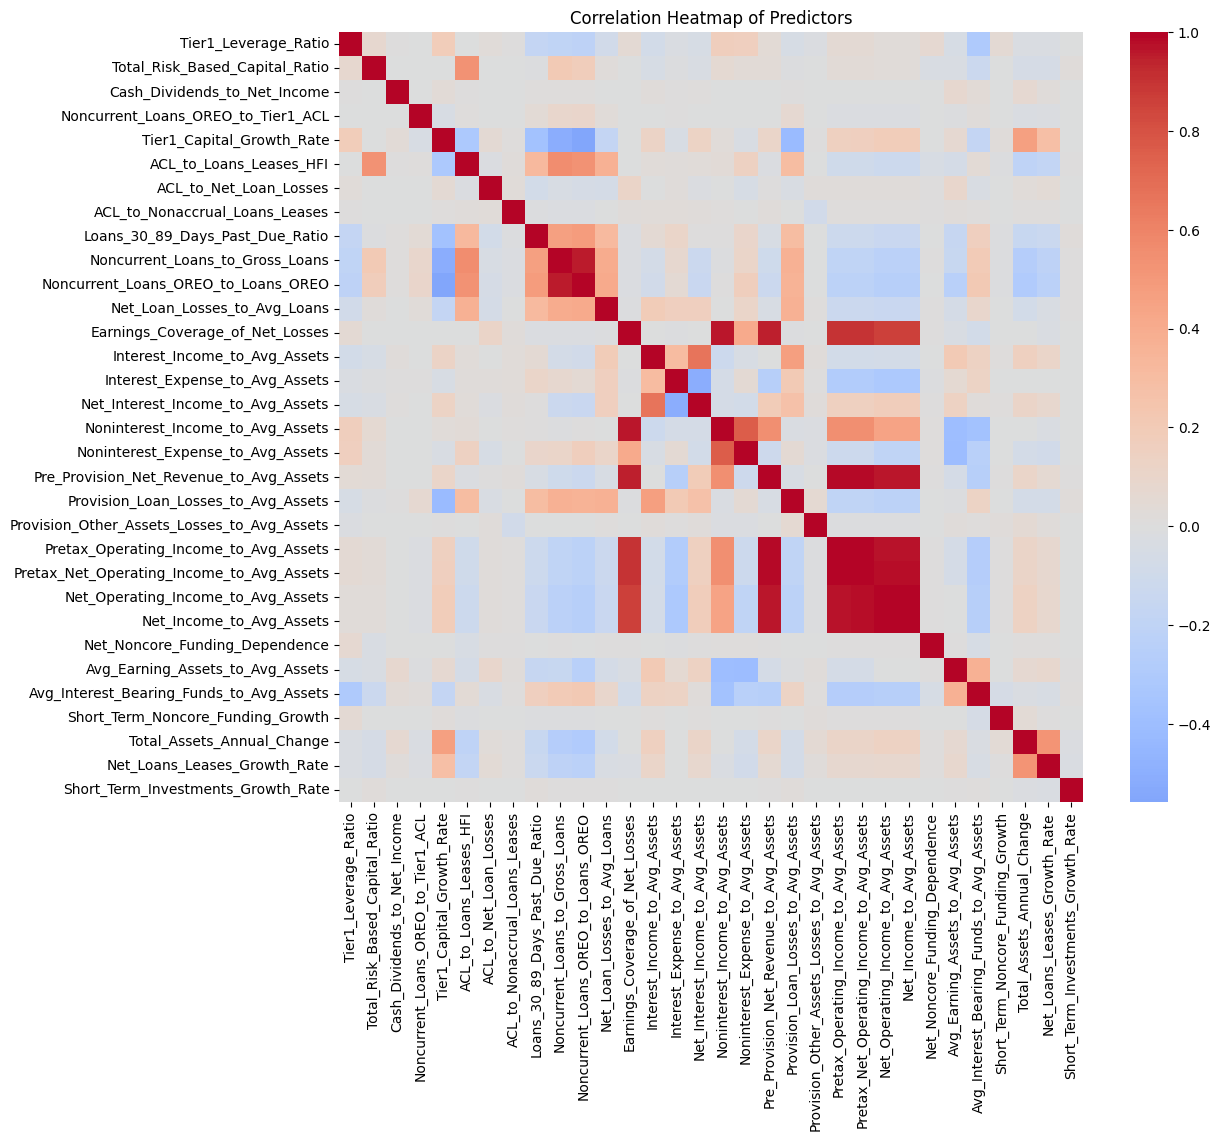

In [8]:
# ==================================
# Step 5: Correlation Heatmap
# ==================================
plt.figure(figsize=(12,10))
sns.heatmap(X.corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap of Predictors")
plt.show()

# Data distribution

In [9]:
# --- Make sure features and target are defined ---
X = df[features].apply(pd.to_numeric, errors="coerce")
y = df["FAIL_FLAG"].astype(int)

df_stats = pd.concat([X, y], axis=1)

summary_list = []

for col in features:
    for label in [0, 1]:  # stratify by FAIL_FLAG
        subset = df_stats[df_stats["FAIL_FLAG"] == label][col]
        
        summary_list.append({
            "Variable": col,
            "FAIL_FLAG": label,
            "Mean": subset.mean(),
            "Std": subset.std(),
            "Median": subset.median(),
            "Q1": subset.quantile(0.25),
            "Q3": subset.quantile(0.75),
            "Missing %": subset.isna().mean() * 100,
            "N": subset.shape[0]
        })

summary_df = pd.DataFrame(summary_list)

# Round for readability
summary_df = summary_df.round(3)

# Pivot to compare 0 vs 1 side by side
summary_pivot = summary_df.pivot(
    index="Variable",
    columns="FAIL_FLAG",
    values=["Mean", "Std", "Median", "Q1", "Q3", "Missing %", "N"]
)

# Flatten multi-index
summary_pivot.columns = [f"{stat}_Fail{flag}" for stat, flag in summary_pivot.columns]
summary_pivot = summary_pivot.reset_index()

print(summary_pivot)  


                                       Variable  Mean_Fail0  Mean_Fail1  \
0                       ACL_to_Loans_Leases_HFI       1.510       4.696   
1                        ACL_to_Net_Loan_Losses      84.161      25.527   
2                ACL_to_Nonaccrual_Loans_Leases      26.706       0.510   
3              Avg_Earning_Assets_to_Avg_Assets      93.254      90.608   
4      Avg_Interest_Bearing_Funds_to_Avg_Assets      70.304      86.816   
5                  Cash_Dividends_to_Net_Income     -23.653     345.718   
6               Earnings_Coverage_of_Net_Losses     195.064      -3.367   
7                Interest_Expense_to_Avg_Assets       1.426       1.911   
8                 Interest_Income_to_Avg_Assets       4.867       4.201   
9               Loans_30_89_Days_Past_Due_Ratio       0.914       4.541   
10                     Net_Income_to_Avg_Assets       0.809      -6.192   
11            Net_Interest_Income_to_Avg_Assets       3.440       2.289   
12                 Net_Lo